<a href="https://colab.research.google.com/github/Akeshh/ICS661-Assignment3-part1/blob/main/ICS661_A3_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import json
import os
from tqdm import tqdm
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import nltk
import string

In [3]:
# Load and print a portion of the train and test data
with open('/content/drive/MyDrive/CS661-Assignment2/train_data.json', 'r') as train_file, open('/content/drive/MyDrive/CS661-Assignment2/test_data.json', 'r') as test_file:
    train_data = json.load(train_file)
    test_data = json.load(test_file)

print("Train data example:", train_data[:1])
print("Test data example:", test_data[:1])

Train data example: [{'review': "bromwell high cartoon comedy ran time programs school life teachers 35 years teaching profession lead believe bromwell high 's satire closer reality teachers scramble survive financially insightful students right pathetic teachers pomp pettiness situation remind schools knew students saw episode student repeatedly tried burn school immediately recalled high classic line inspector 'm sack teachers student welcome bromwell high expect adults age think bromwell high far fetched pity n't", 'label': 'pos', 'score': 9}]
Test data example: [{'review': "went saw movie night coaxed friends 'll admit reluctant knew ashton kutcher able comedy wrong kutcher played character jake fischer kevin costner played ben randall professionalism sign good movie toy emotions exactly entire theater sold overcome laughter half movie moved tears second half exiting theater saw women tears grown men trying desperately let crying movie great suggest judge", 'label': 'pos', 'score':

In [9]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

# Tokenizer for BERT
bert_model_name = 'mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis'
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

# Function to tokenize and convert input data for BERT with tqdm progress bar
def preprocess_for_bert(texts, tokenizer, max_len=256):
    # Prepare empty lists to store tokenized inputs and attention masks
    input_ids_list = []
    attention_mask_list = []

    # Use tqdm to show the progress of tokenization
    for text in tqdm(texts, desc="Tokenizing data"):
        encoding = tokenizer(text, truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
        input_ids_list.append(encoding['input_ids'])
        attention_mask_list.append(encoding['attention_mask'])

    # Stack them together into tensors
    input_ids = torch.cat(input_ids_list, dim=0)
    attention_mask = torch.cat(attention_mask_list, dim=0)

    return input_ids, attention_mask

# Read reviews and labels from the JSON data
train_reviews = [item['review'] for item in tqdm(train_data, desc="Reading train data")]
train_labels = [1 if item['label'] == 'pos' else 0 for item in train_data]

test_reviews = [item['review'] for item in tqdm(test_data, desc="Reading test data")]
test_labels = [1 if item['label'] == 'pos' else 0 for item in test_data]

# Preprocess the reviews using BERT tokenizer with progress bars
train_input_ids, train_attention_mask = preprocess_for_bert(train_reviews, tokenizer)
test_input_ids, test_attention_mask = preprocess_for_bert(test_reviews, tokenizer)

# Convert labels to tensors
train_labels = torch.tensor(train_labels, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

# Create TensorDataset with input_ids, attention_mask, and labels
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)


print("Data loaded and prepared for BERT.")

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing data: 100%|██████████| 25000/25000 [00:19<00:00, 1298.79it/s]


Data loaded and prepared for BERT.


In [12]:
import torch
import torch.nn as nn
from transformers import AutoModel

# Define a new model class that uses BERT embeddings
class SentimentBERT(nn.Module):
    def __init__(self, bert_model_name, output_size, drop_prob=0.5):
        super(SentimentBERT, self).__init__()

        # Load the BERT model
        self.bert = AutoModel.from_pretrained(bert_model_name)

        # Fully connected layer for classification (output_size changed to 2 for binary classification with CrossEntropyLoss)
        self.fc = nn.Linear(self.bert.config.hidden_size, output_size)

        # Dropout layer
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, input_ids, attention_mask):
        # Pass the inputs through BERT to get the contextualized embeddings
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_output.last_hidden_state  # Get the last hidden states

        # Apply dropout and pass through fully connected layer
        out = self.dropout(last_hidden_state[:, 0, :])  # Use the [CLS] token representation
        out = self.fc(out)

        return out

# Define the model
output_size = 2  # Output size is 2 for binary classification with CrossEntropyLoss


model = SentimentBERT(bert_model_name, output_size)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

# Loss function (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-05)


Some weights of RobertaModel were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SentimentBERT(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(

In [7]:
def train_model(model, train_loader, test_loader, criterion, optimizer, n_epochs=10, device='cpu'):
    # Track loss and accuracy history
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    model.to(device)  # Ensure model is on the correct device

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop with tqdm progress bar
        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} Training")
        for input_ids, attention_mask, labels in train_loader_iter:
            # Move input data to the appropriate device
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass through the model
            outputs = model(input_ids, attention_mask)

            # CrossEntropyLoss expects labels as long, and no need for sigmoid
            loss = criterion(outputs, labels.long())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item() * input_ids.size(0)

            # Accuracy calculation: outputs are logits, take argmax for predictions
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            # Debugging: Print predictions and labels (optional)
            if epoch == 0 and total_train < 100:  # Only print for the first epoch and small batch for readability
                print(f"Predictions: {preds[:10]}")  # Print first 10 predictions
                print(f"Labels: {labels[:10]}")      # Print first 10 labels

        train_loss = running_loss / total_train
        train_acc = correct_train / total_train

        # Append train metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Evaluate on test set with progress bar
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    return train_losses, train_accuracies, test_losses, test_accuracies


def evaluate_model(model, data_loader, criterion, device='cpu'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        data_loader_iter = tqdm(data_loader, desc="Evaluating")
        for input_ids, attention_mask, labels in data_loader_iter:
            # Move input data to the appropriate device
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            # Forward pass through the model
            outputs = model(input_ids, attention_mask)

            # CrossEntropyLoss expects labels as long, no need for sigmoid
            loss = criterion(outputs, labels.long())

            running_loss += loss.item() * input_ids.size(0)

            # Accuracy calculation: outputs are logits, take argmax for predictions
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Debugging: Print predictions and labels for the first few batches
            if total < 100:  # Only print for the first 100 samples for readability
                print(f"Predictions: {preds[:10]}")  # Print first 10 predictions
                print(f"Labels: {labels[:10]}")      # Print first 10 labels

    avg_loss = running_loss / total
    accuracy = correct / total  # Ensure accuracy is between 0-1

    # Debugging: print correct and total to verify accuracy calculation
    print(f"Correct: {correct}, Total: {total}, Accuracy: {accuracy}")

    return avg_loss, accuracy


# Function to plot loss and accuracy
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, n_epochs):
    import matplotlib.pyplot as plt

    epochs = range(1, n_epochs + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/5 Training:   0%|          | 1/391 [00:00<04:13,  1.54it/s]

Predictions: tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
Labels: tensor([1., 1., 1., 0., 1., 0., 1., 1., 0., 1.], device='cuda:0')


Evaluating:   0%|          | 1/391 [00:00<01:30,  4.29it/s]

Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Labels: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


Evaluating: 100%|██████████| 391/391 [01:32<00:00,  4.21it/s]


Correct: 22298, Total: 25000, Accuracy: 0.89192
Epoch 1/5 - Train Loss: 0.3425, Train Accuracy: 0.8560, Test Loss: 0.2592, Test Accuracy: 0.8919


Evaluating:   0%|          | 1/391 [00:00<01:30,  4.29it/s]

Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Labels: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


Evaluating: 100%|██████████| 391/391 [01:32<00:00,  4.21it/s]


Correct: 22531, Total: 25000, Accuracy: 0.90124
Epoch 2/5 - Train Loss: 0.2584, Train Accuracy: 0.8970, Test Loss: 0.2430, Test Accuracy: 0.9012


Evaluating:   0%|          | 1/391 [00:00<01:32,  4.20it/s]

Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Labels: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


Evaluating: 100%|██████████| 391/391 [01:32<00:00,  4.21it/s]


Correct: 22187, Total: 25000, Accuracy: 0.88748
Epoch 3/5 - Train Loss: 0.1964, Train Accuracy: 0.9277, Test Loss: 0.3028, Test Accuracy: 0.8875


Evaluating:   0%|          | 1/391 [00:00<01:34,  4.13it/s]

Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Labels: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


Evaluating: 100%|██████████| 391/391 [01:32<00:00,  4.21it/s]


Correct: 22675, Total: 25000, Accuracy: 0.907
Epoch 4/5 - Train Loss: 0.1554, Train Accuracy: 0.9431, Test Loss: 0.2454, Test Accuracy: 0.9070


Evaluating:   0%|          | 1/391 [00:00<01:31,  4.25it/s]

Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Labels: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


Evaluating: 100%|██████████| 391/391 [01:32<00:00,  4.21it/s]


Correct: 22598, Total: 25000, Accuracy: 0.90392
Epoch 5/5 - Train Loss: 0.1145, Train Accuracy: 0.9598, Test Loss: 0.2755, Test Accuracy: 0.9039


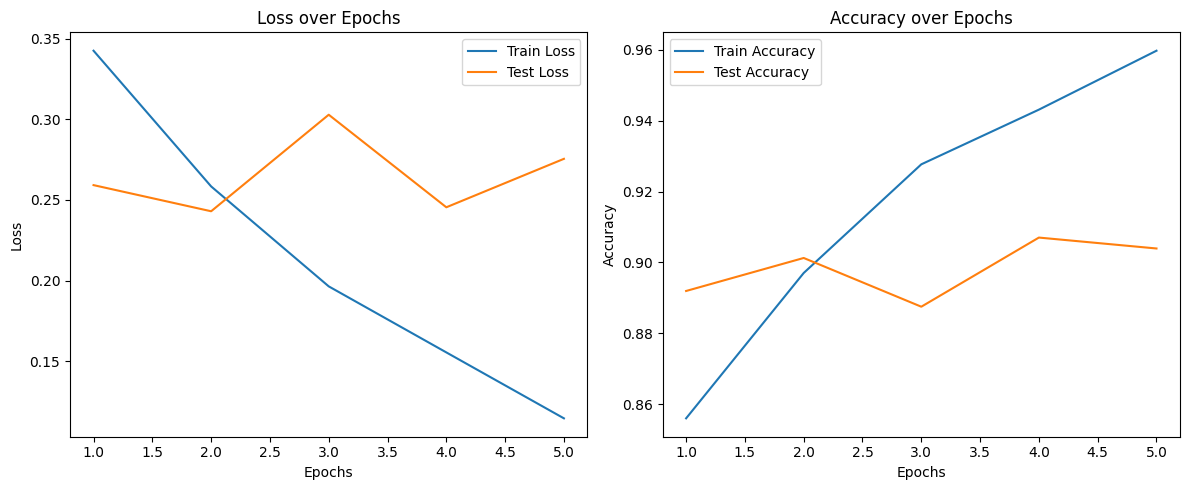

In [13]:
# Define batch size
batch_size = 64

# Create DataLoader for train and test dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

n_epochs = 5
train_losses, train_accuracies, test_losses, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, n_epochs=n_epochs, device=device
)

plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, n_epochs)